import

In [1]:
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd

from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
from flashtorch_modefied import CNN_wrapper, Backprop, SaliencyMap

config_plots.global_settings()

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
experimentName="biology_paper_medium_curated3_50_30"
trial_hash="d136f2dc84aaaee7ea2420a87f4ece93e6fb400d60ad702781ed1d11" #HGNN

cuda=7

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 7


importLoad experiment

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

load dataset and model

In [5]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

# Create the model
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()
fineList = test_loader.dataset.csv_processor.getFineList()
coarseList = test_loader.dataset.csv_processor.getCoarseList()
numberOffine = len(fineList)
numberOfcoarse = len(coarseList)
architecture = {
    "fine": numberOffine,
    "coarse" : numberOfcoarse
}
model = CNN.create_model(architecture, experiment_params, device=cuda)

{'experimentName': 'biology_paper_medium_curated3_50_30', 'modelName': 'models/d136f2dc84aaaee7ea2420a87f4ece93e6fb400d60ad702781ed1d11', 'datasetName': 'datasplits/46951392423537f47b73e60a13110e434f3db01bb4ee6b1ffb48969f', 'experimentHash': '8cfa4d66f84aa8a449c7b08a577cd3cbeaed4558f2f2e77b7edda21c', 'trialHash': 'd136f2dc84aaaee7ea2420a87f4ece93e6fb400d60ad702781ed1d11', 'image_path': 'Curated3/Medium', 'suffix': 'curated_30_50', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.0001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.9}
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


Load model of a specific trial

In [6]:
# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)

df, epochs, time_elapsed = CNN.loadModel(model, trialName, device=cuda)

Model wrapper

In [7]:
wrapped_model = CNN_wrapper(model, experiment_params, test_loader.dataset)

Saliency map of one image

In [8]:
# params
wrapped_model.setOutputsOfInterest({
    "fine": True,
    "coarse" : False
})
fileName= '/raid/elhamod/Fish/Curated3/Medium/curated_30_50/test/Luxilus cornutus/43066_lat_FMNH_FZ_m.jpg'

layerName = "fine"
# "input": x,
# "hy_features": hy_features,
# "hb_features": hb_features,
# "gy_features": gy_features if outputs["fine"] else None,
# "gc_features": gc_features if outputs["coarse"] else None,
# "coarse": yc if outputs["coarse"] and modelType_has_coarse else None,
# "fine": y if outputs["fine"] else None

Number of activations:  torch.Size([1, 102])


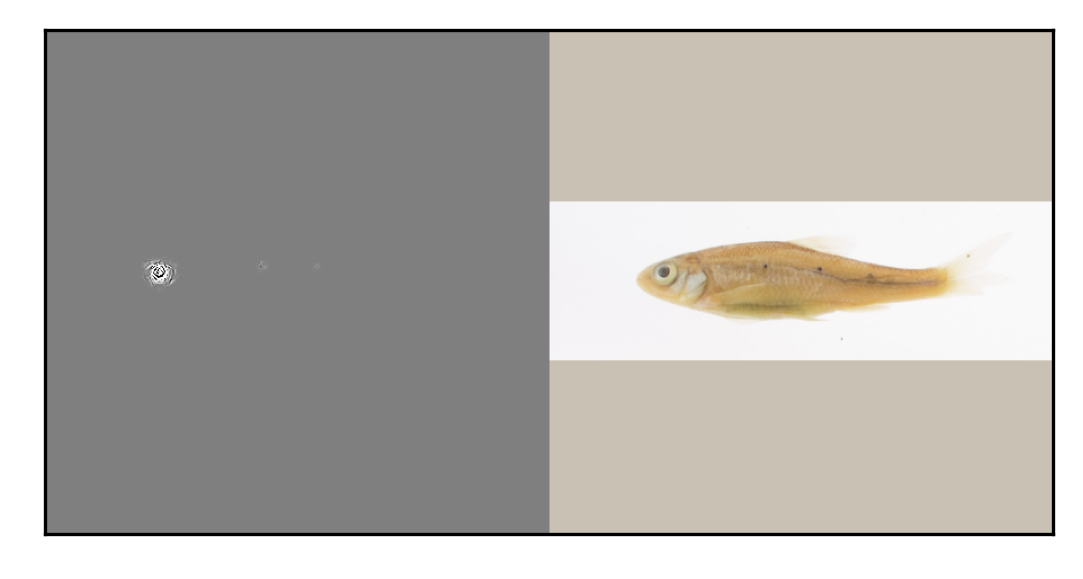

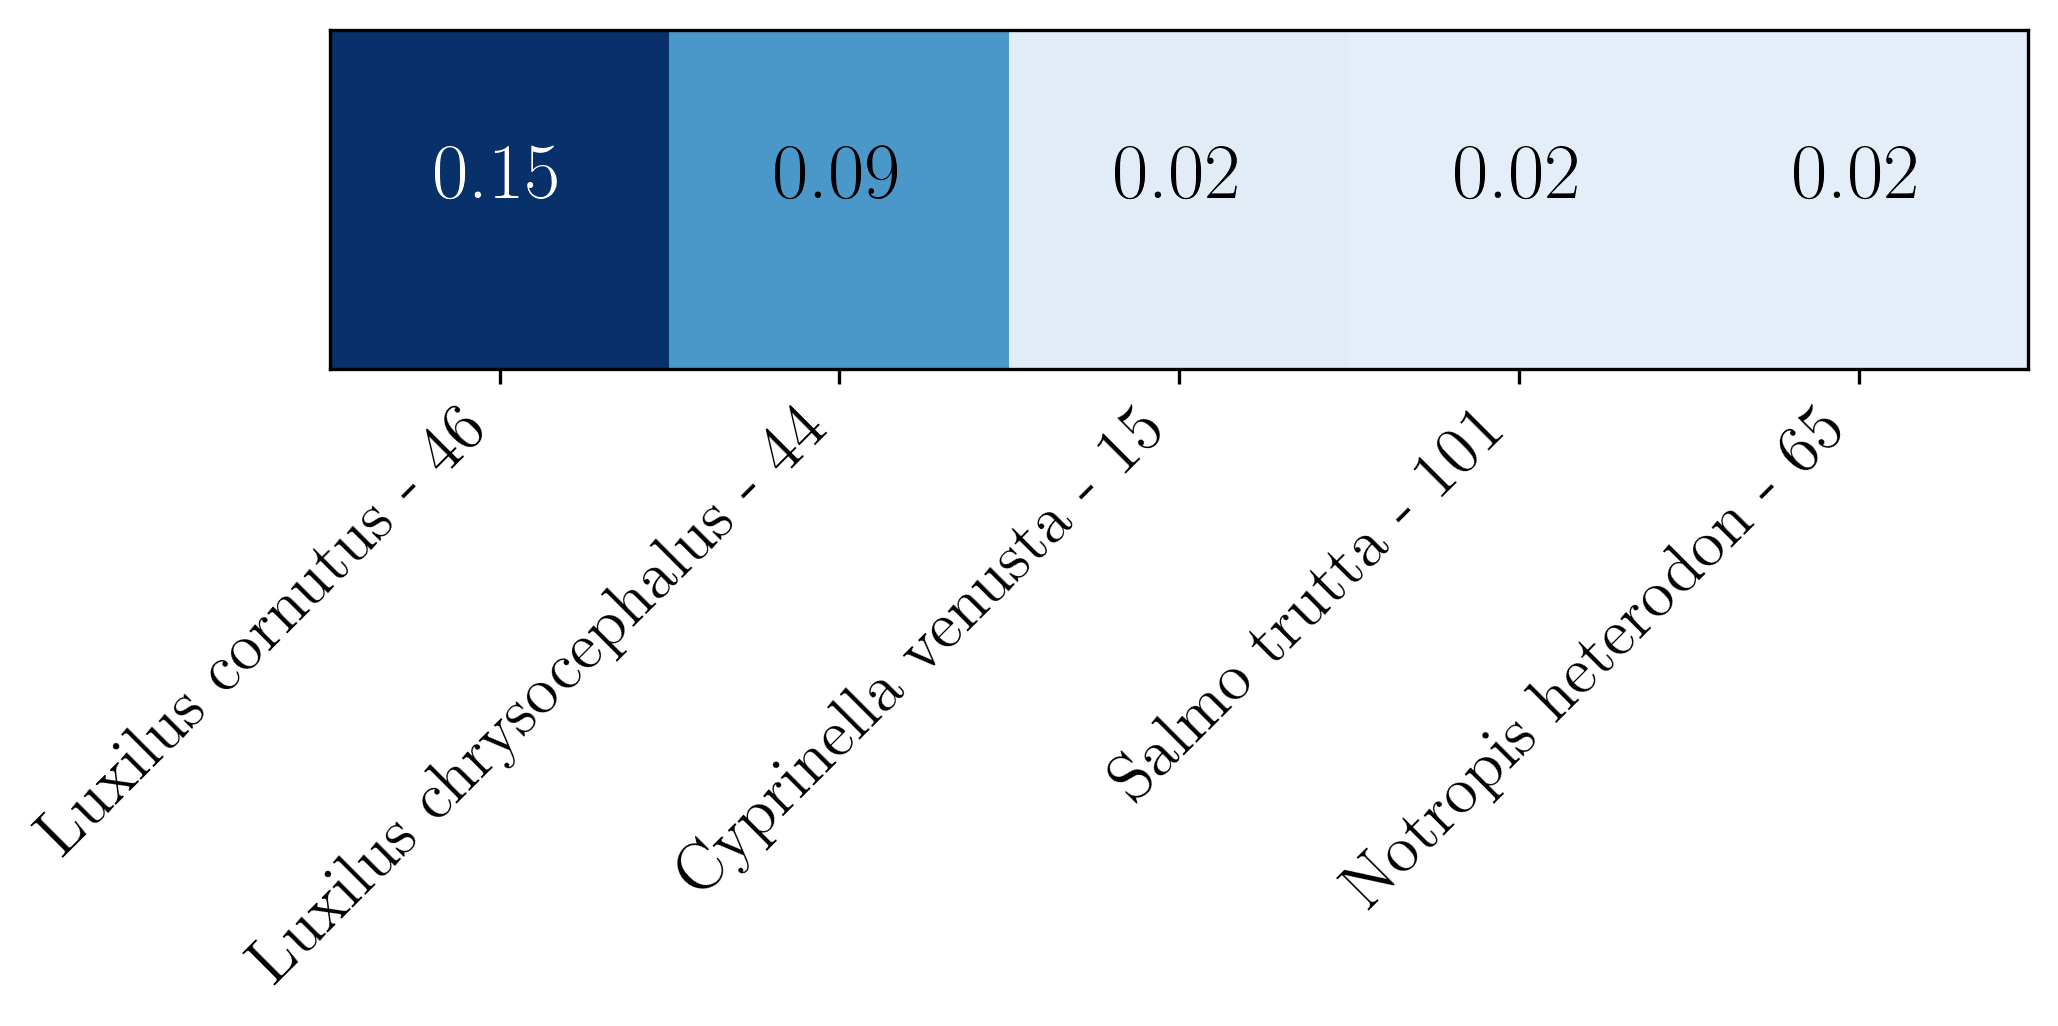

In [9]:
# %%capture
import os
from torchvision import transforms as torchvision_transforms
from skimage import io

saliencyMap = SaliencyMap(test_loader.dataset, wrapped_model, experimentPathAndName, trial_hash, experiment_params)
_, _ = saliencyMap.GetSaliencyMap(fileName, layerName, use_gpu=True)

box_width =  39
Number of activations:  torch.Size([1, 102])


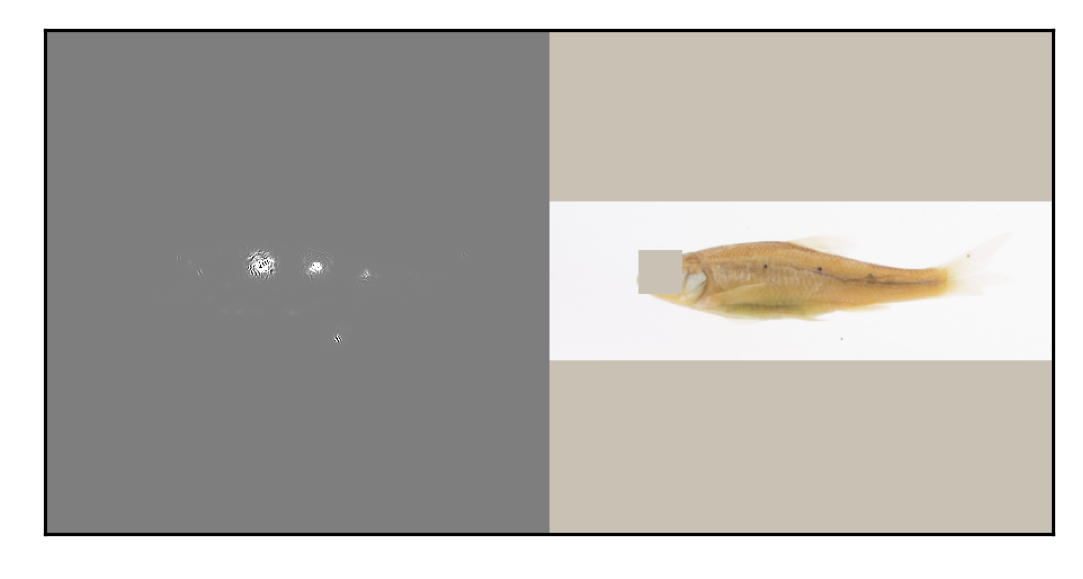

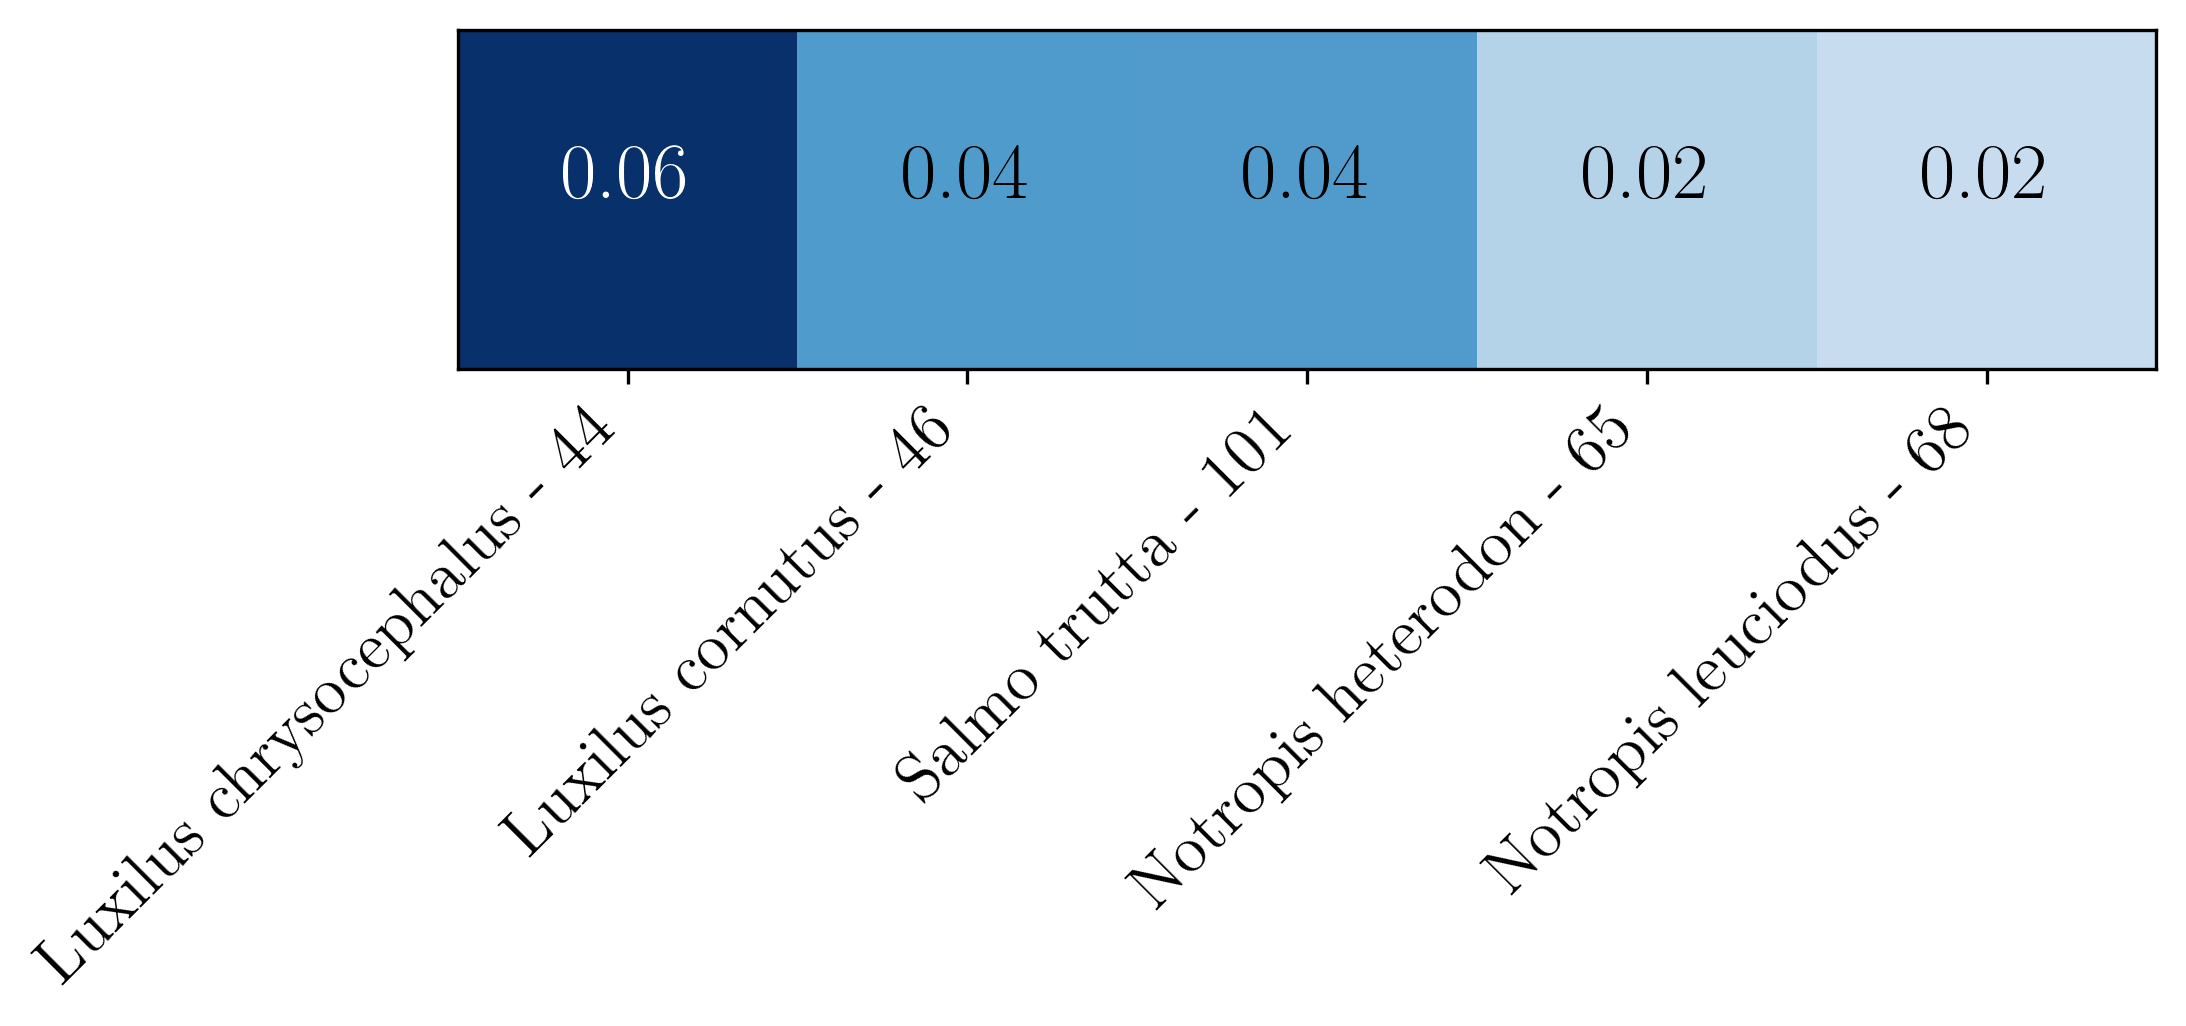

Number of activations:  torch.Size([1, 102])


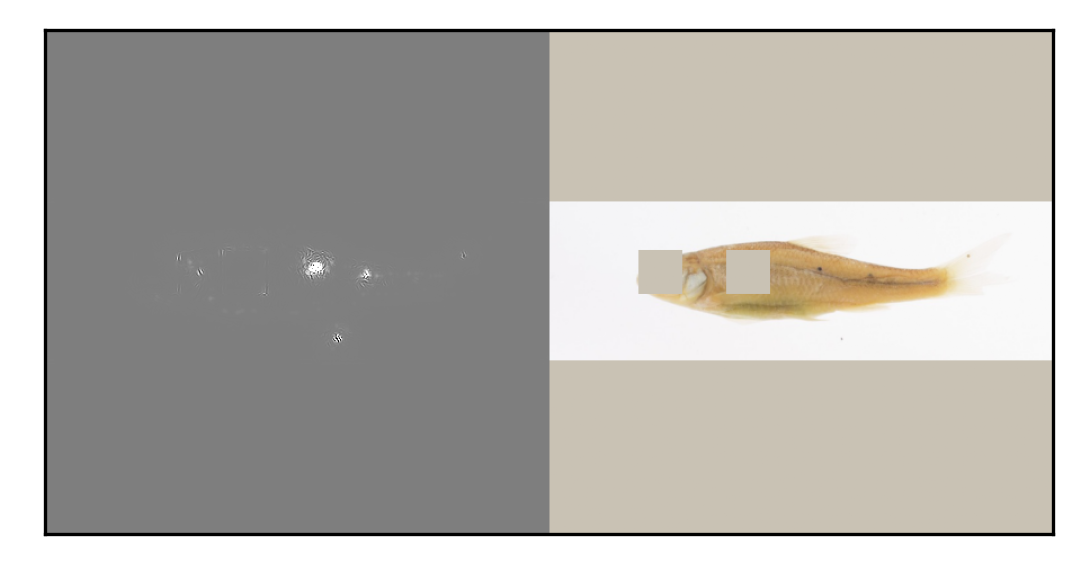

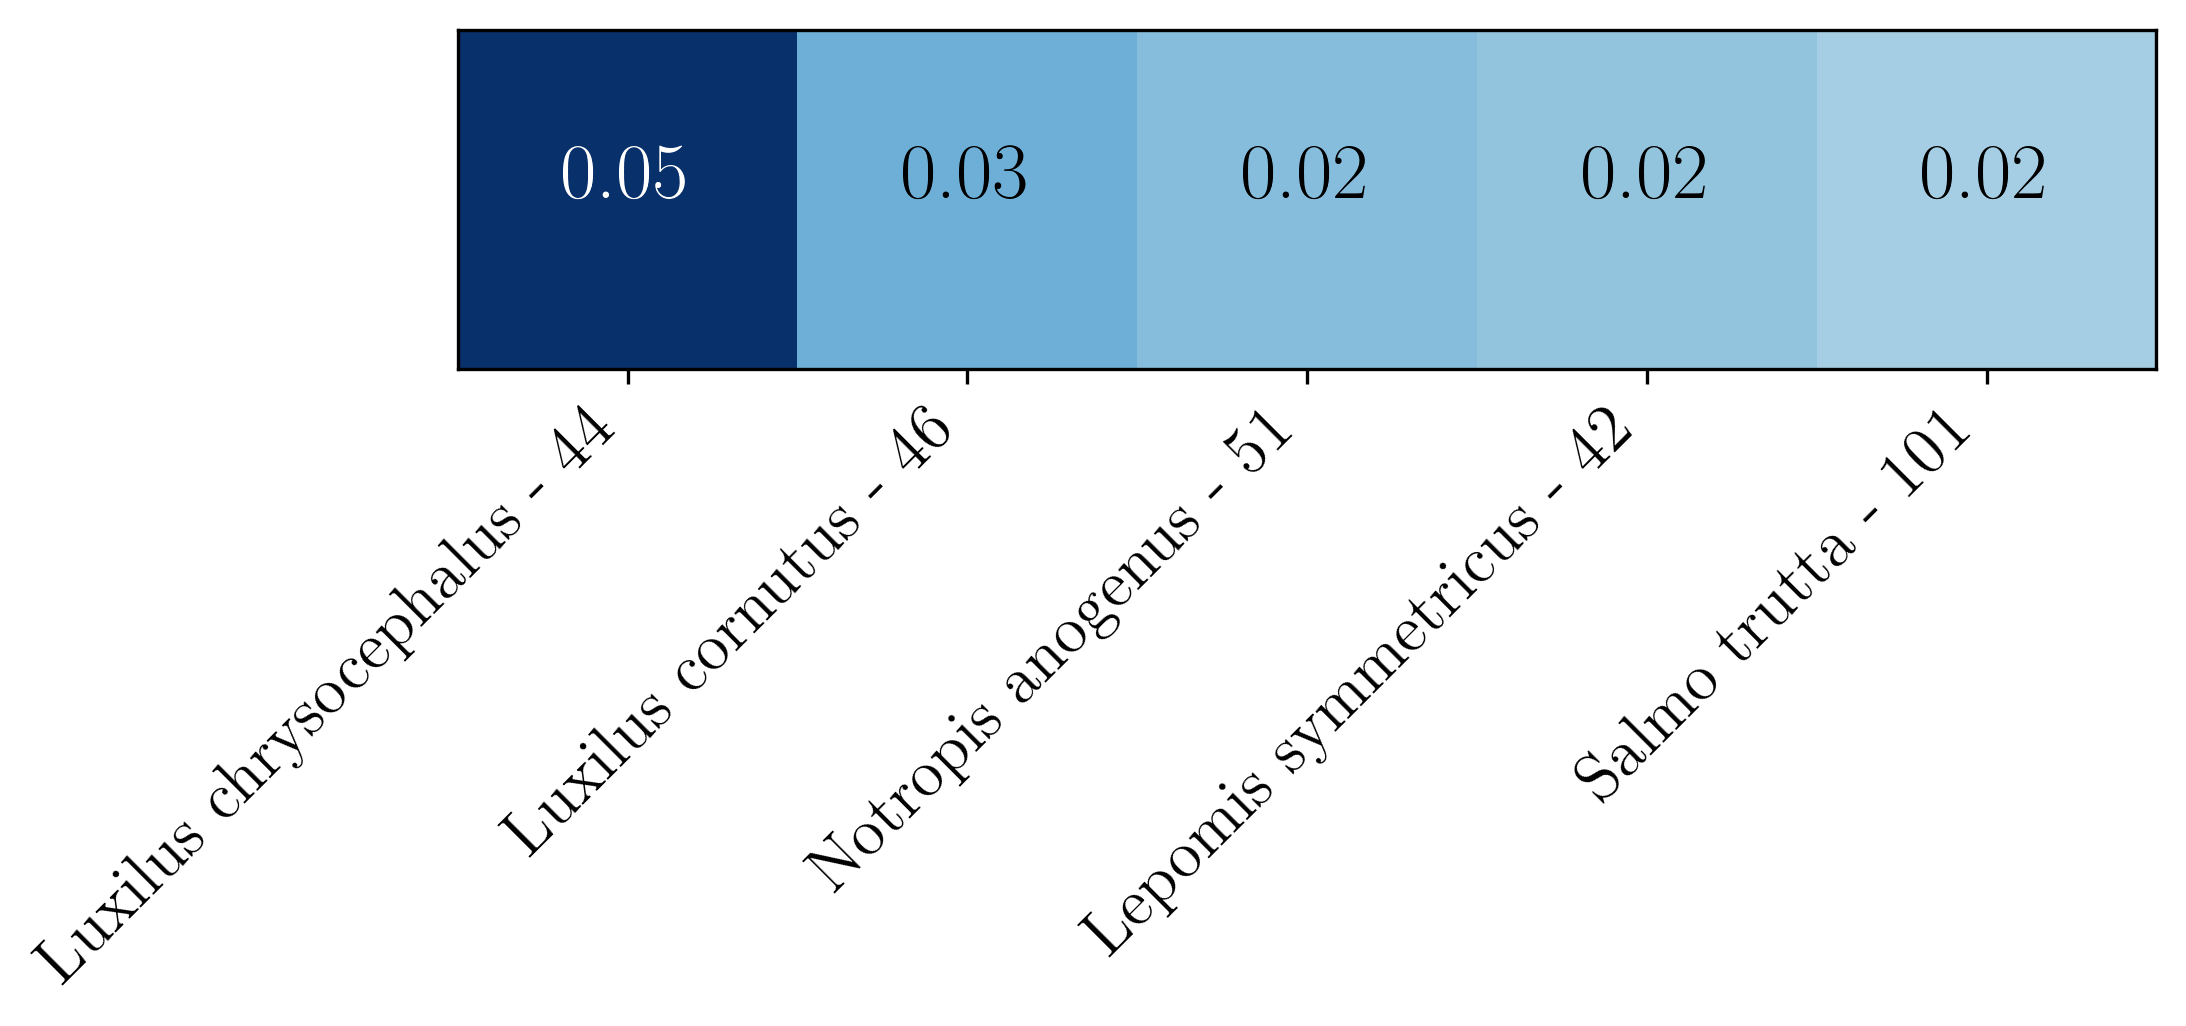

Number of activations:  torch.Size([1, 102])


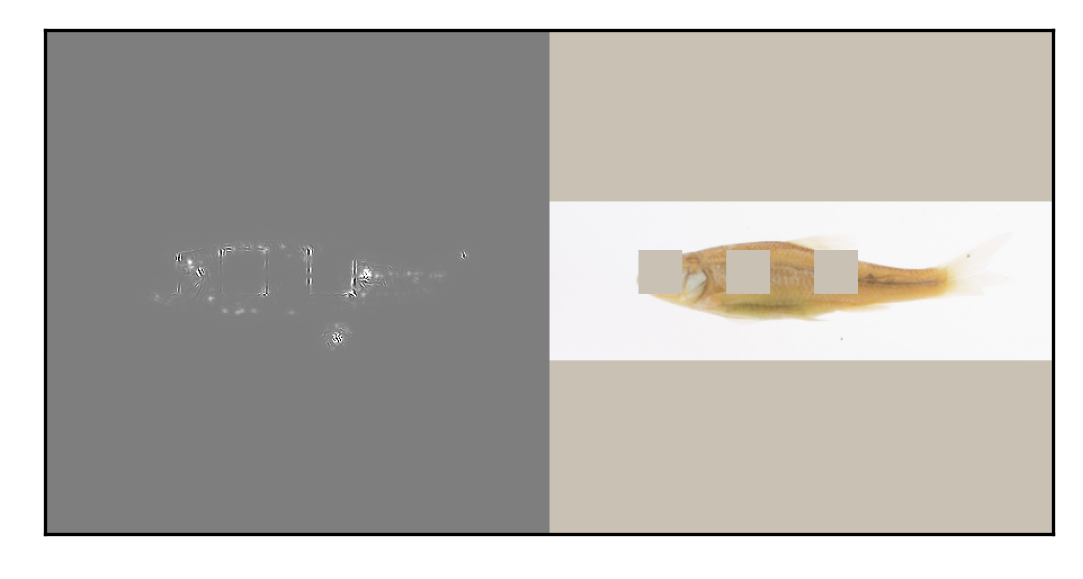

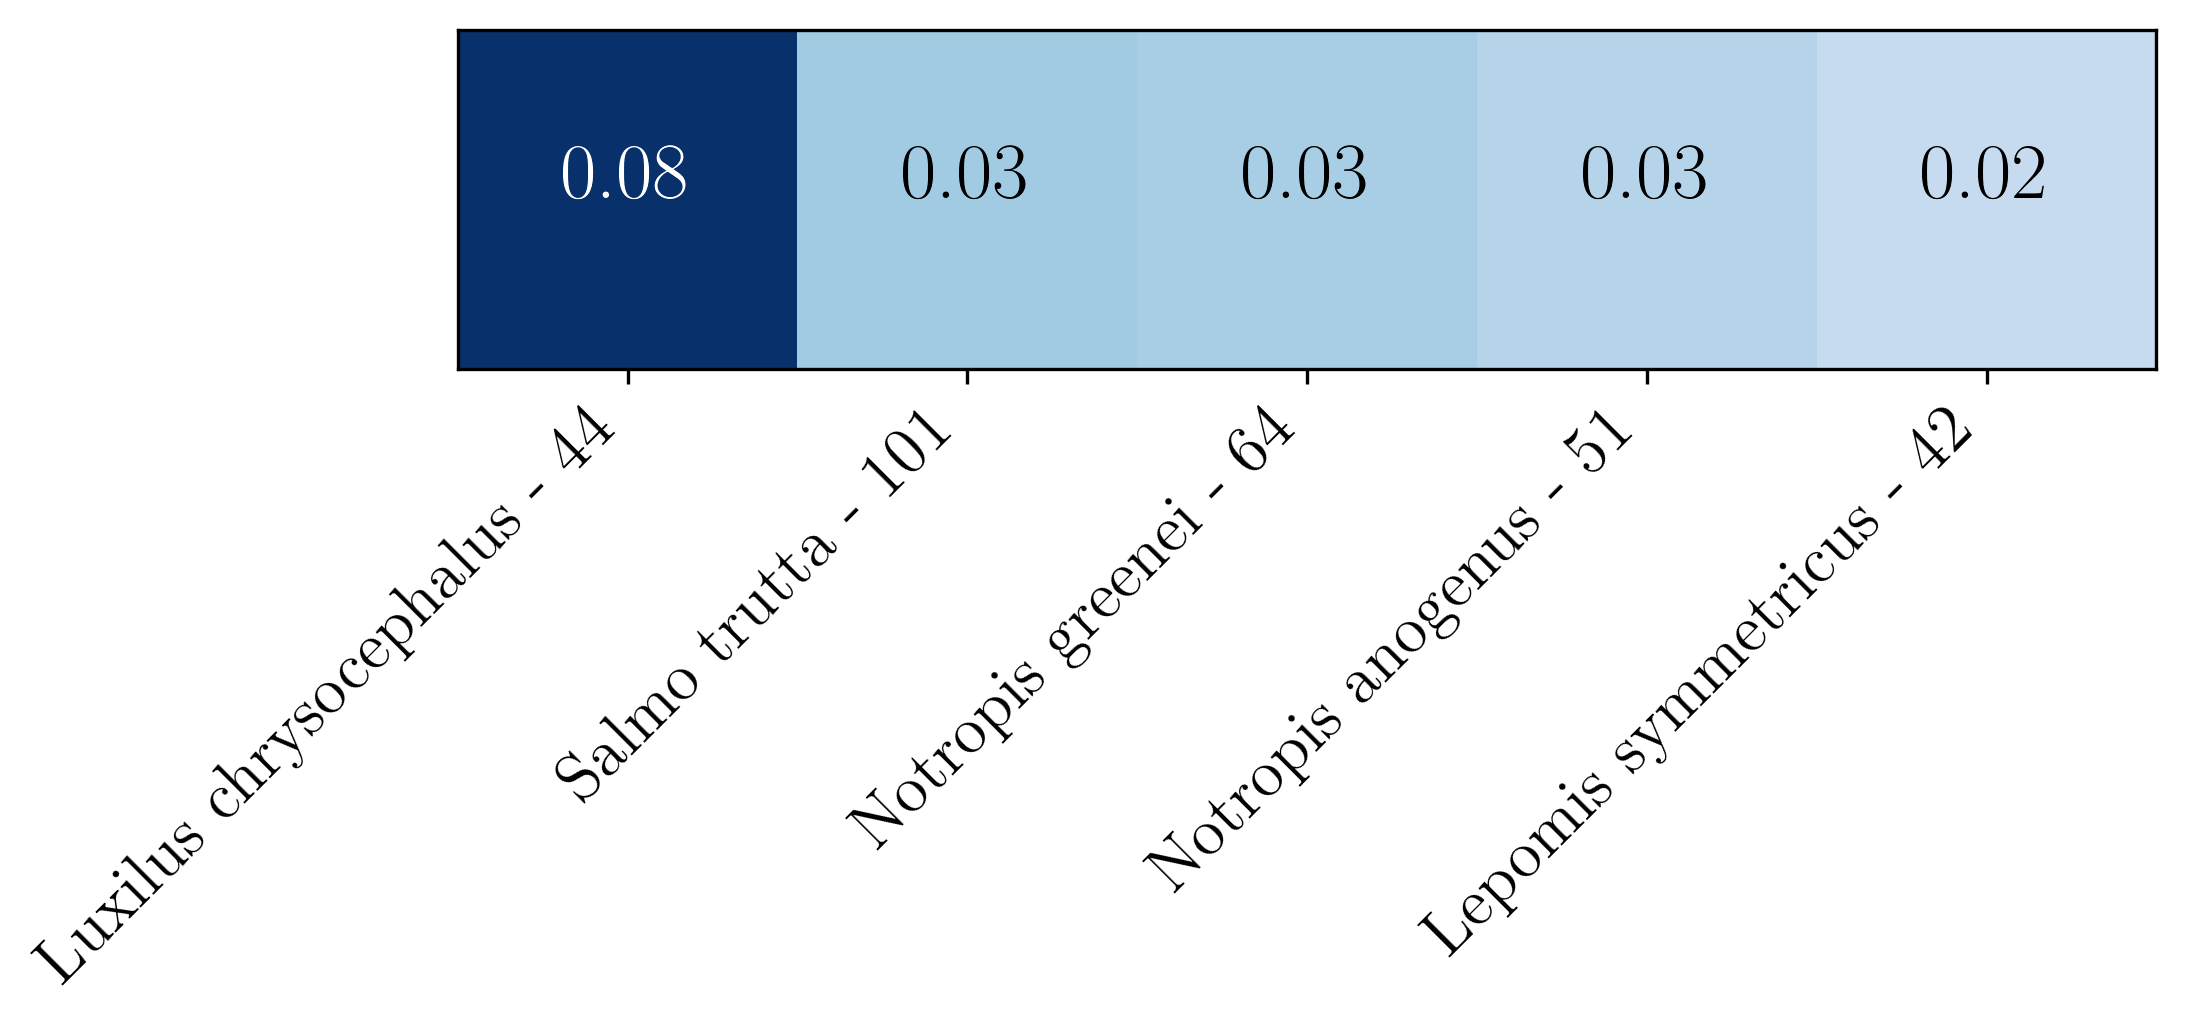

Number of activations:  torch.Size([1, 102])


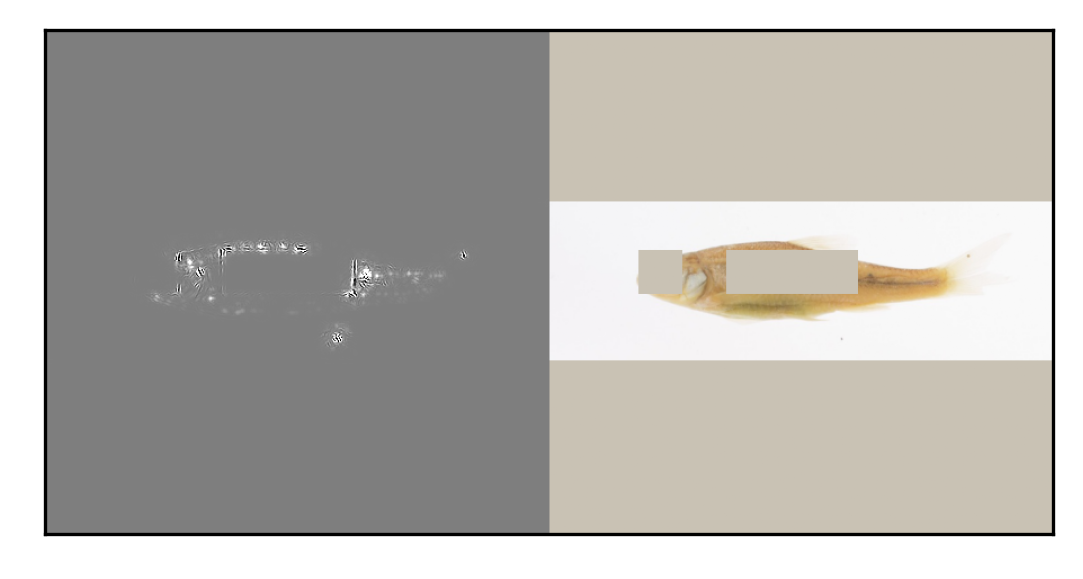

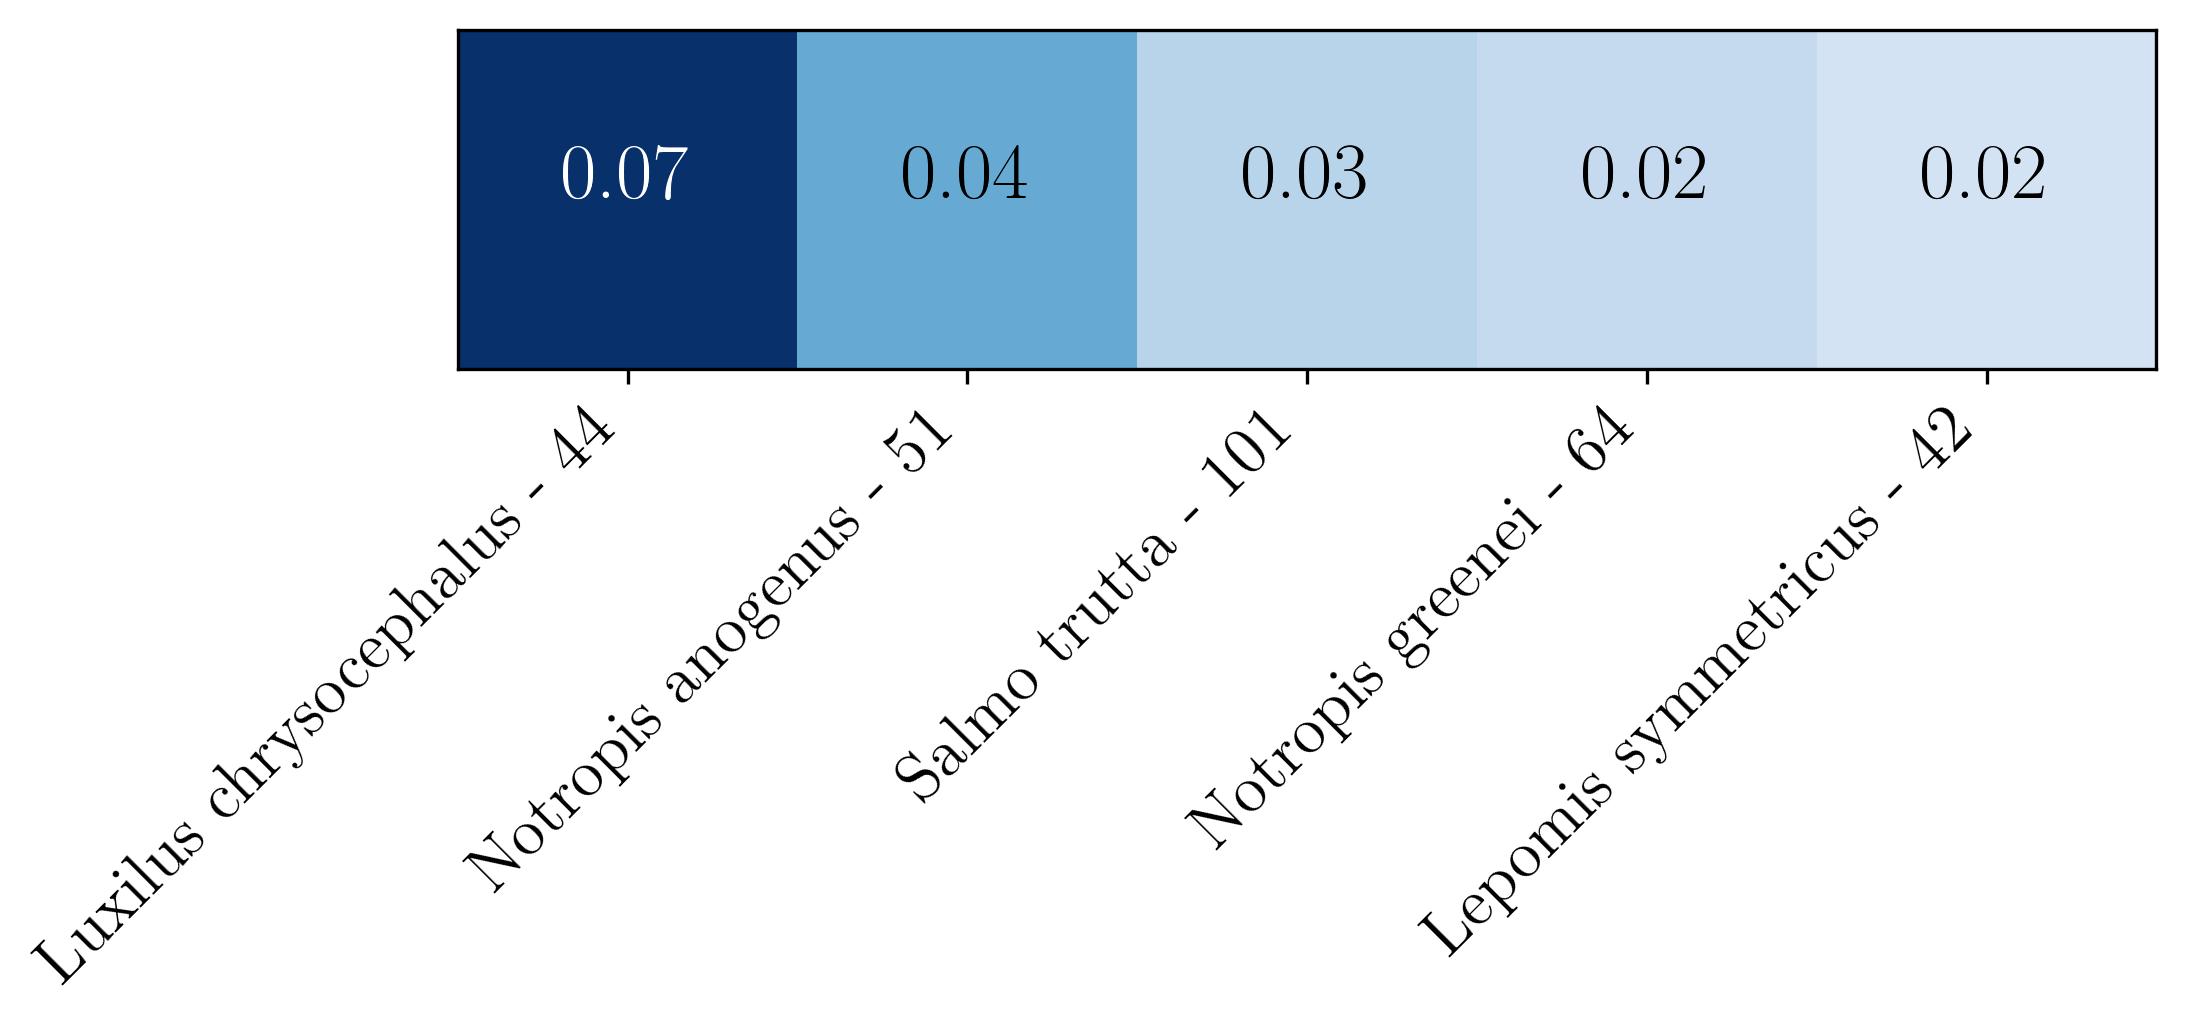

box_width =  49
Number of activations:  torch.Size([1, 102])


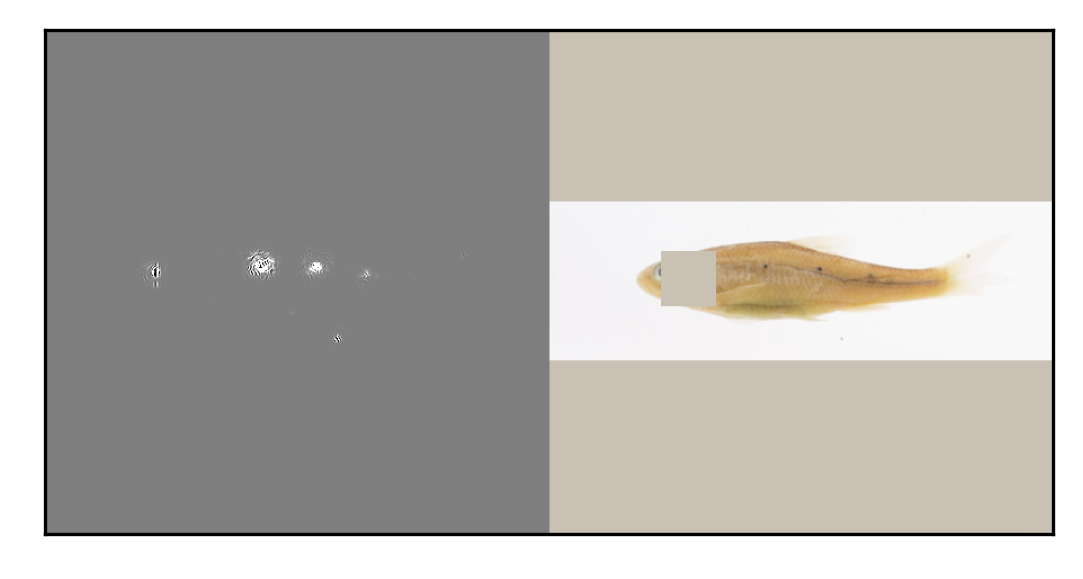

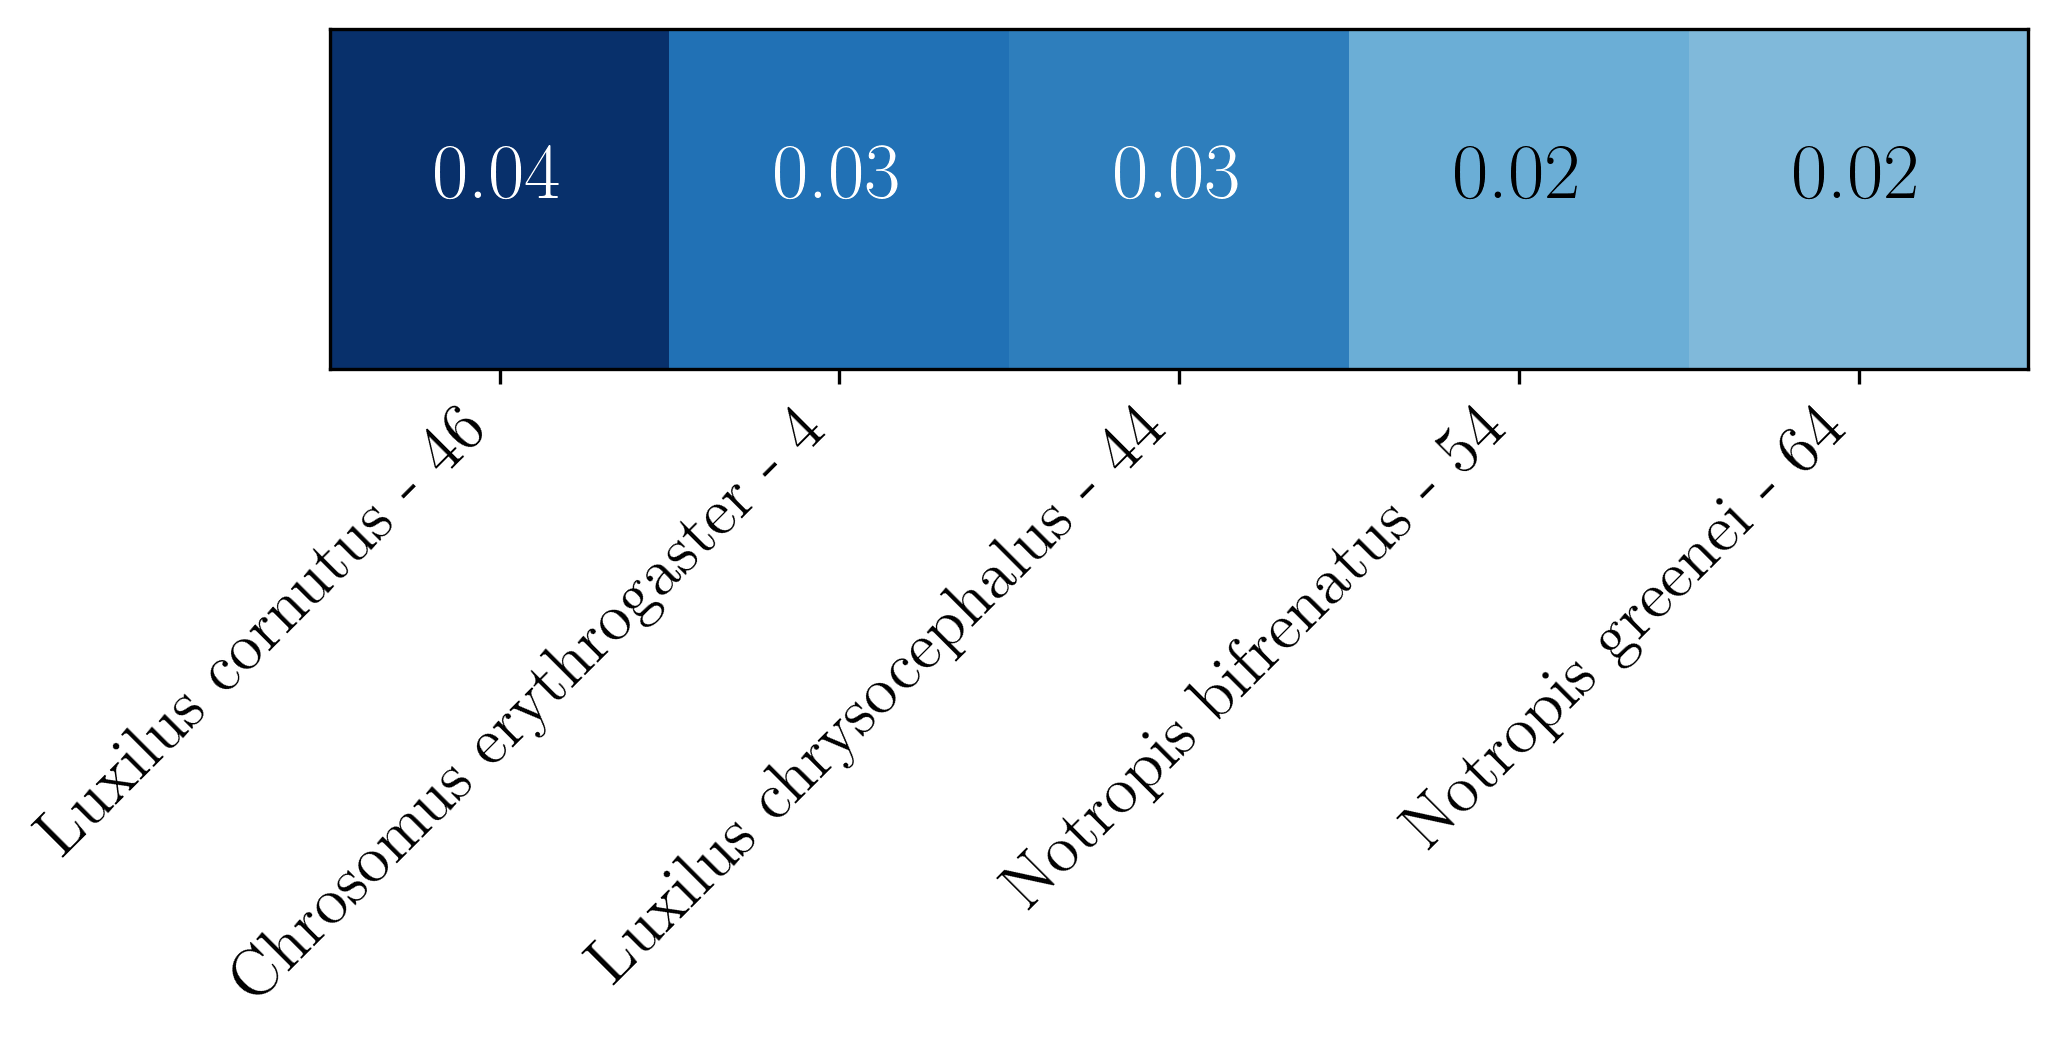

Number of activations:  torch.Size([1, 102])


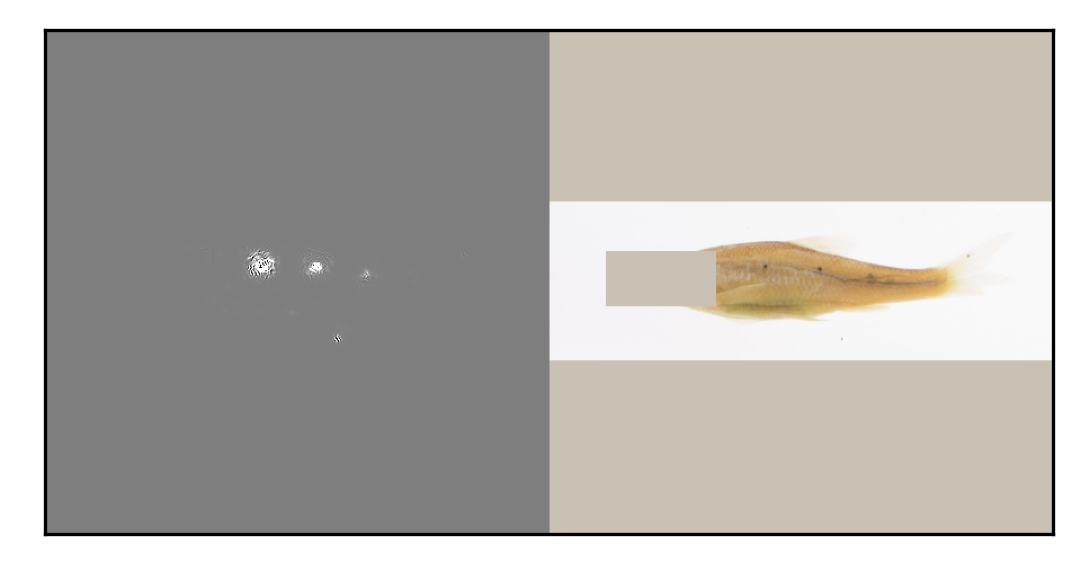

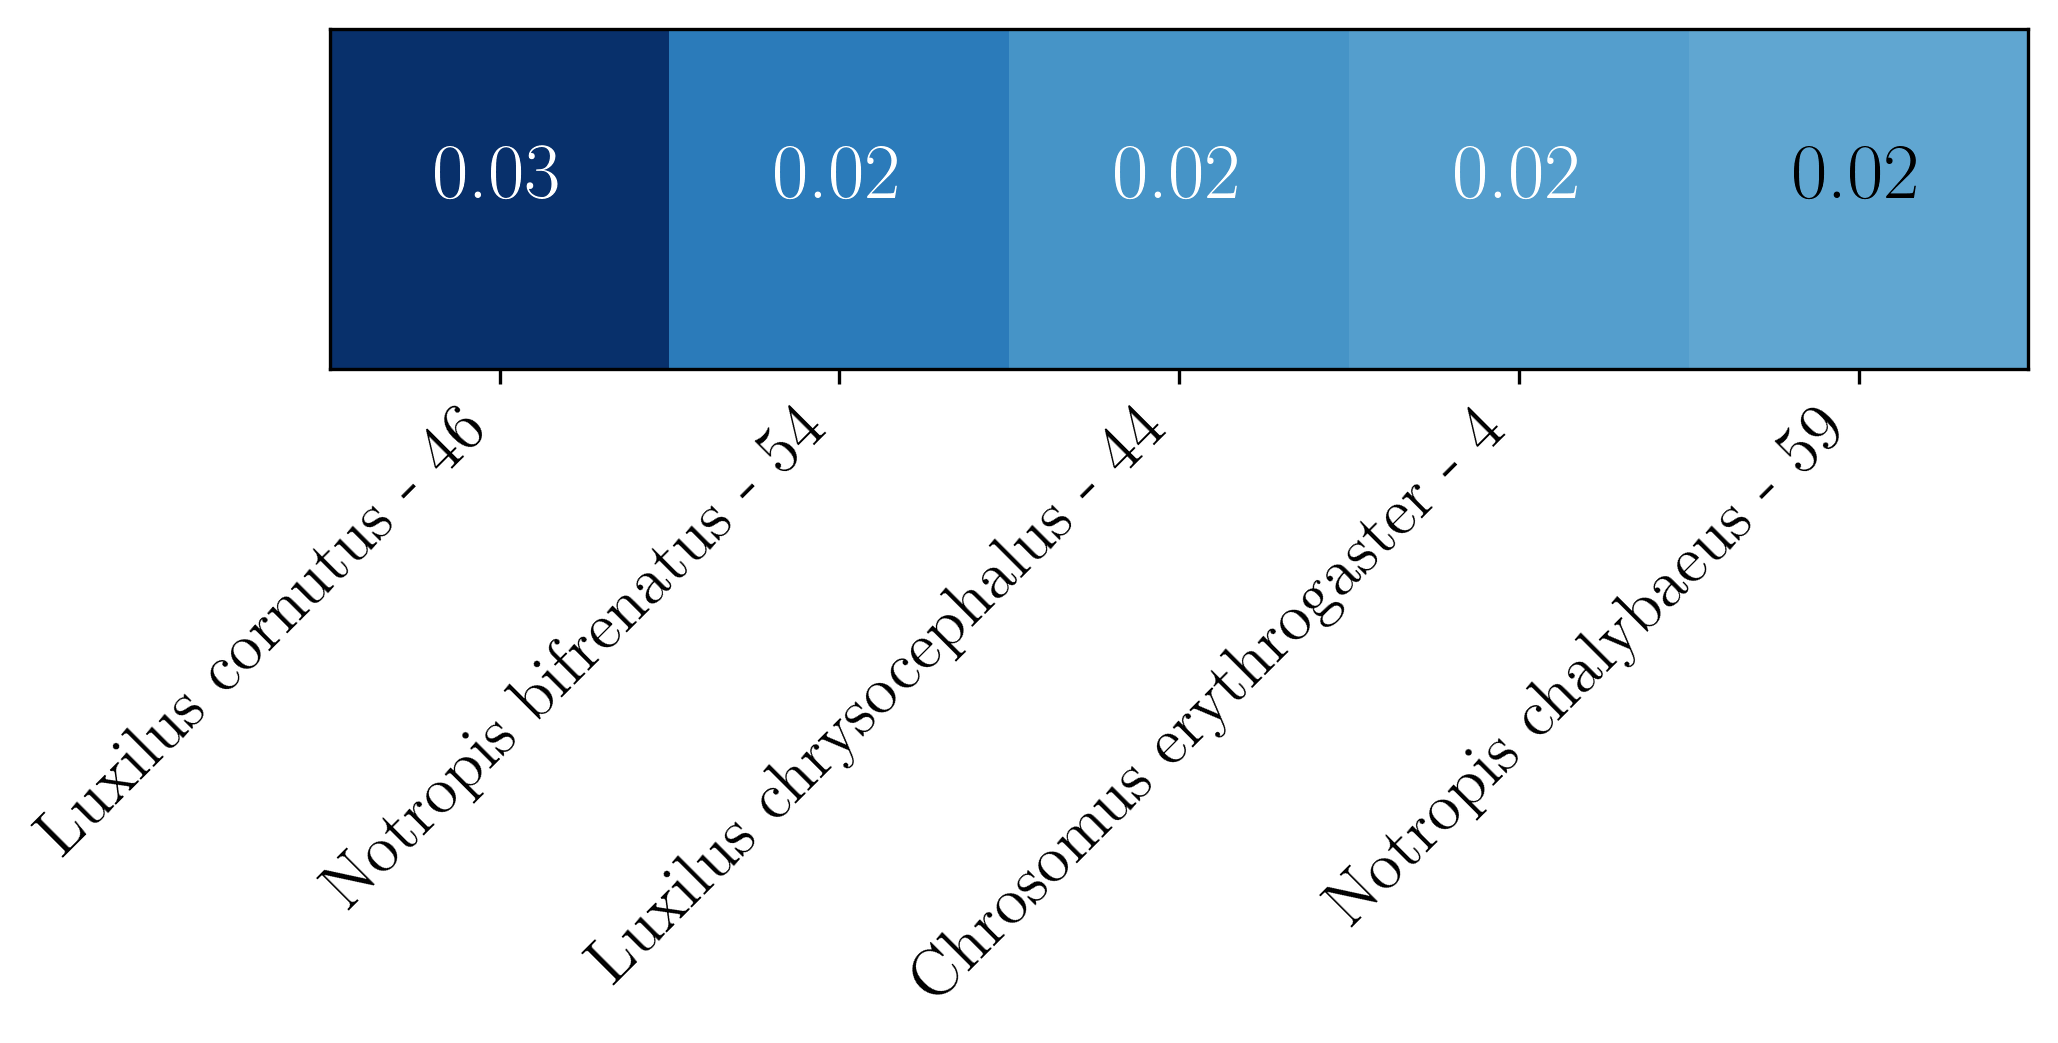

Number of activations:  torch.Size([1, 102])


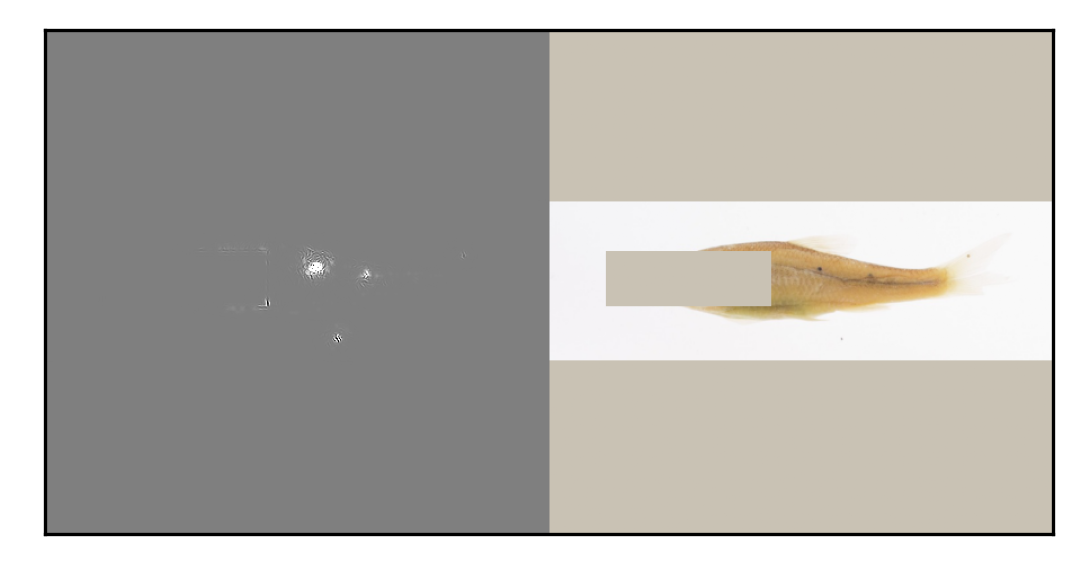

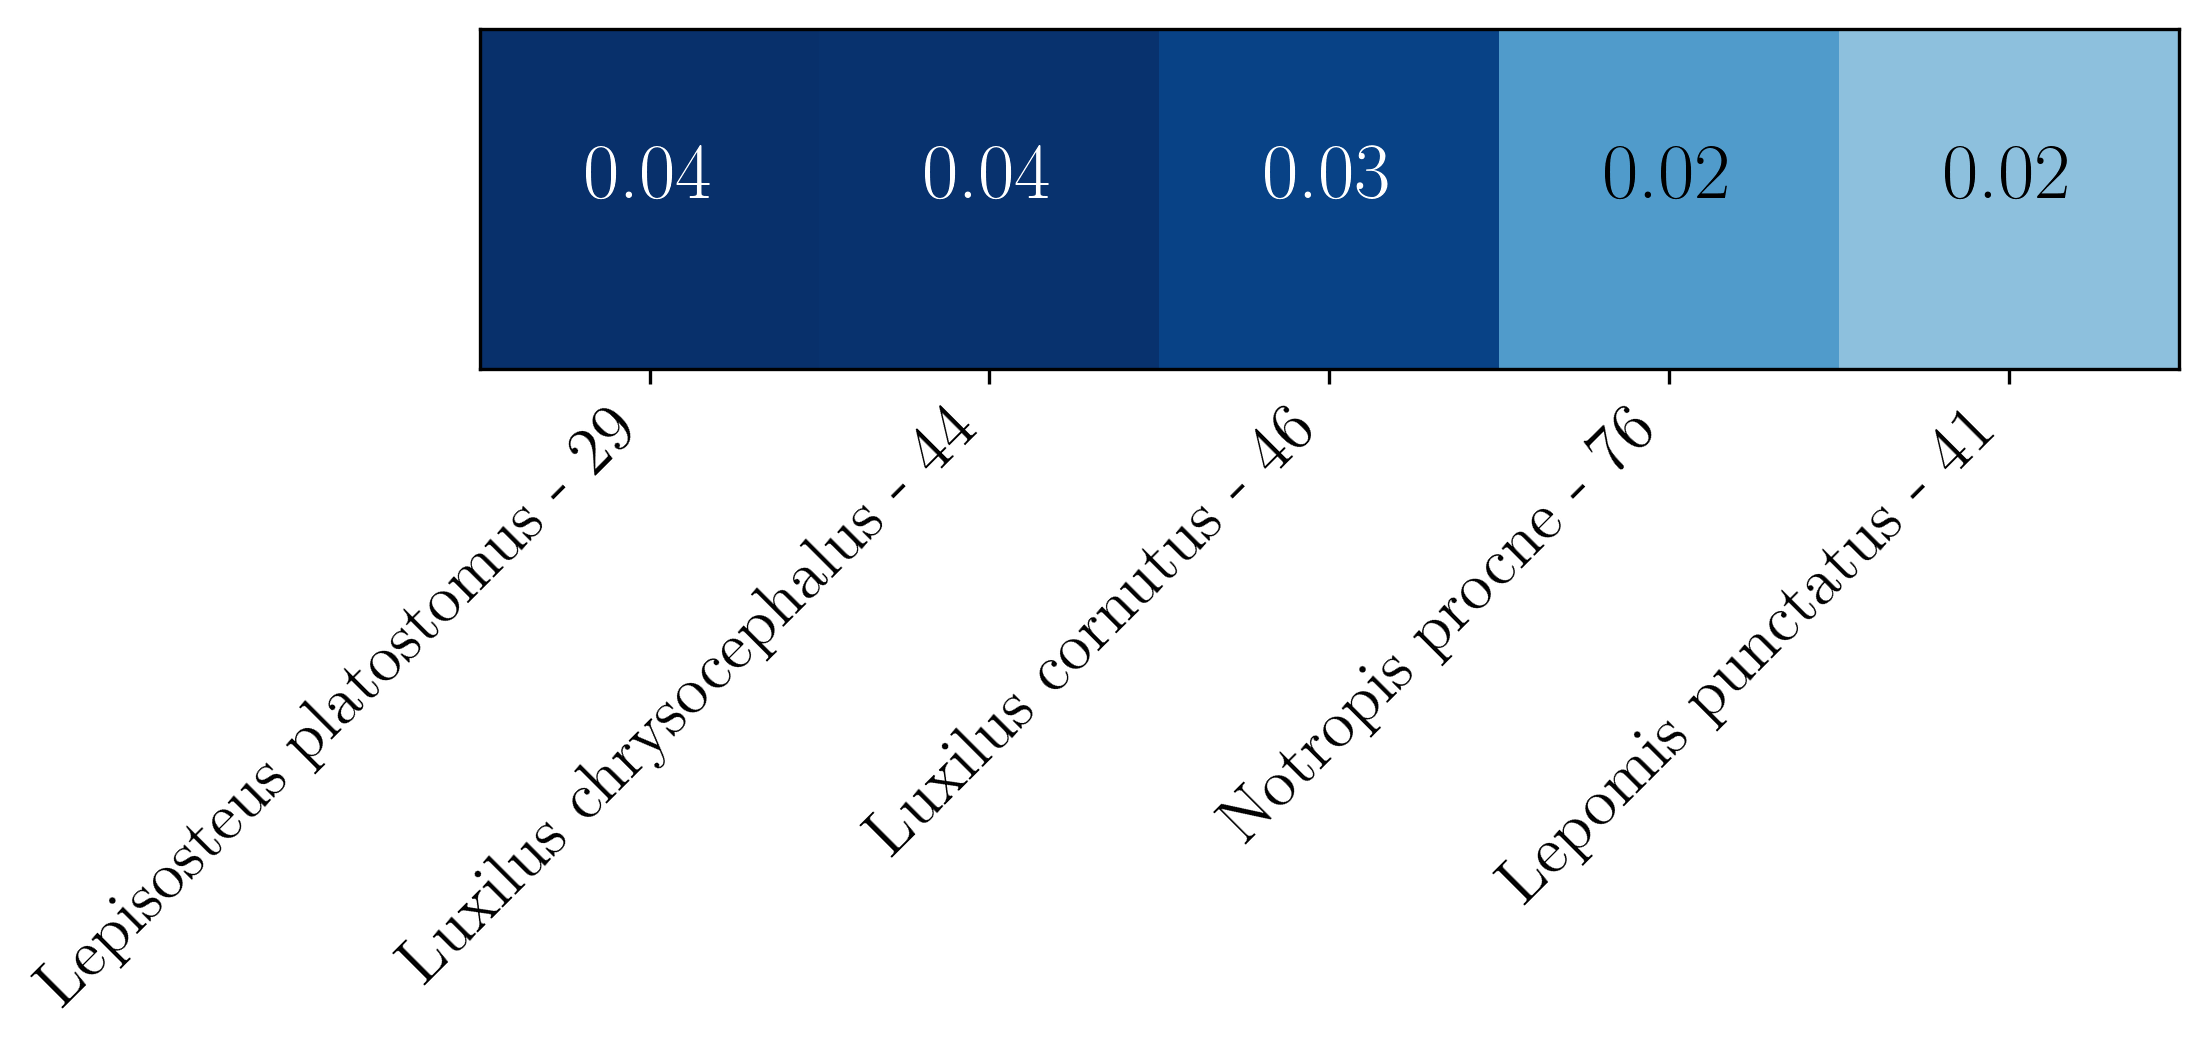

Number of activations:  torch.Size([1, 102])


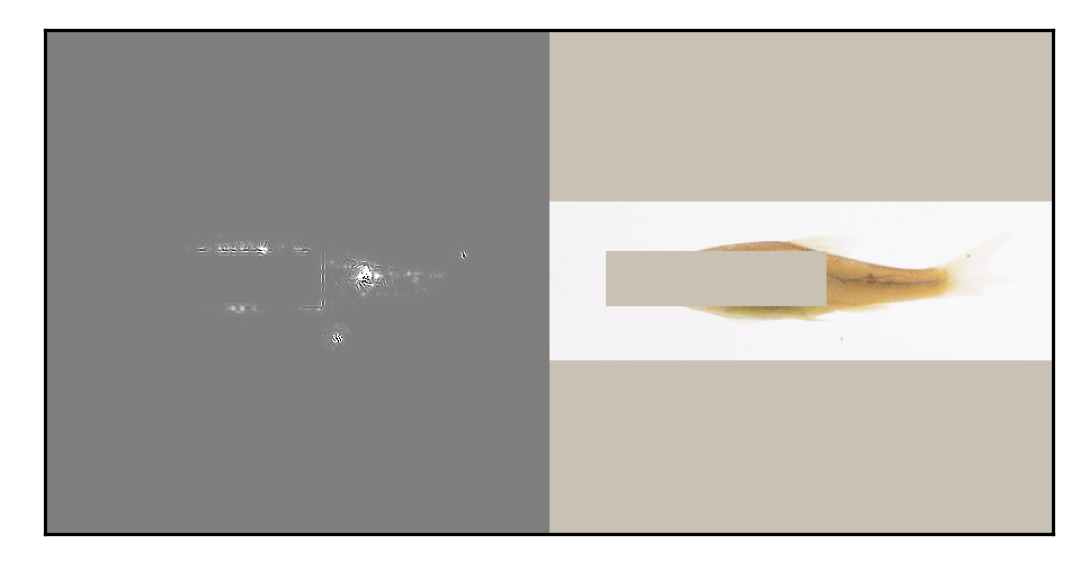

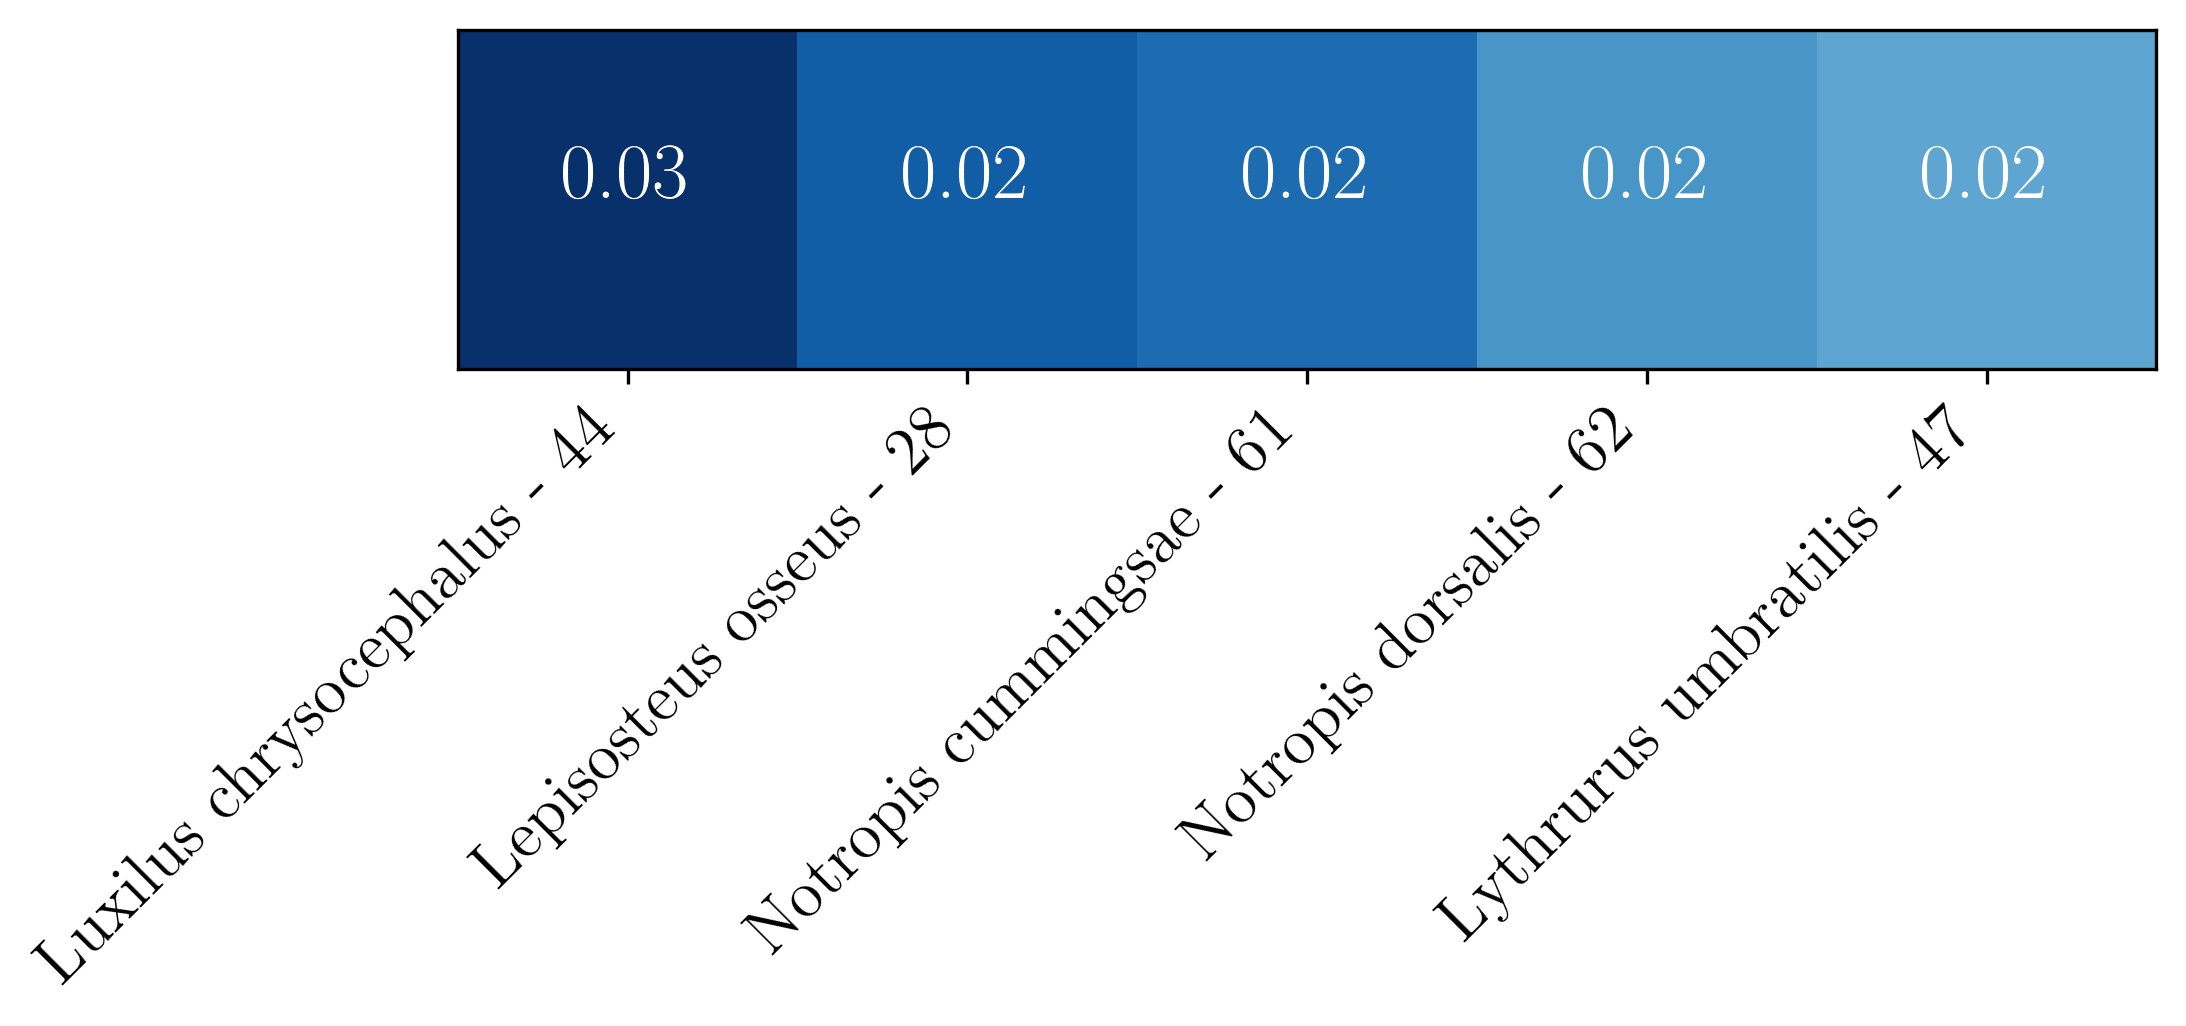

In [10]:
for i in [39 ,49]: #9, 19, 29 ,
    print('box_width = ', i)
    saliencyMap.GetSaliencyMap(fileName,layerName,box_width =i, maxCovered=True, topk=4, use_gpu=True)

List of test images of a certain species

In [11]:
# params
species = 0
###################

train_loader, validation_loader, test_loader = datasetManager.getLoaders()
loader = train_loader

lst = []
for batch in loader:
    lst = lst + [batch['fileName'][indx] for (indx, i) in enumerate(batch['fine']) if i == species]
print(lst)

Creating loaders...
Creating loaders... Done.
['INHS_FISH_49982.JPG', 'INHS_FISH_26150.jpg', 'INHS_FISH_106912.JPG', 'INHS_FISH_63210.JPG', 'INHS_FISH_73683.JPG', 'INHS_FISH_9410.JPG', 'INHS_FISH_65207.jpg', 'INHS_FISH_1447.JPG', 'INHS_FISH_47631.JPG', '74568_lat_FMNH_FZ.jpg', 'INHS_FISH_24054.JPG', 'INHS_FISH_066.JPG', 'INHS_FISH_26278.jpg', 'INHS_FISH_26909.jpg', 'INHS_FISH_6162.jpg', 'INHS_FISH_61191.jpg', 'INHS_FISH_46881.JPG', 'INHS_FISH_105983.JPG', 'INHS_FISH_82164.jpg', 'INHS_FISH_22512.JPG', 'UWZM-F-0000009.JPG', 'INHS_FISH_7725.jpg', 'INHS_FISH_105833.JPG', 'INHS_FISH_103372.JPG', 'INHS_FISH_105107.JPG', '118394_lat_FMNH_FZ.jpg', 'INHS_FISH_42475.JPG', '1518_lat_FMNH_FZ.jpg', 'INHS_FISH_14000.JPG', 'INHS_FISH_48349.JPG', 'INHS_FISH_26965.jpg', 'INHS_FISH_38910.JPG']
